# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [116]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [124]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [125]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [126]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [127]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
print(grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

[ 0.57611688 -0.78805844  0.21194156]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [128]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [130]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [131]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [133]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 731.590077
Epoch 1, loss: 819.230071
Epoch 2, loss: 768.923102
Epoch 3, loss: 886.002130
Epoch 4, loss: 1099.364773
Epoch 5, loss: 707.079689
Epoch 6, loss: 1113.397138
Epoch 7, loss: 768.140792
Epoch 8, loss: 743.859065
Epoch 9, loss: 1025.141056


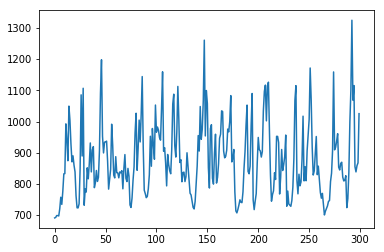

In [134]:
# let's look at the loss history!
plt.plot(loss_history)

In [135]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.164
Epoch 0, loss: 871.043180
Epoch 1, loss: 909.991607
Epoch 2, loss: 865.264042
Epoch 3, loss: 873.989037
Epoch 4, loss: 844.775225
Epoch 5, loss: 821.013493
Epoch 6, loss: 994.170102
Epoch 7, loss: 966.520476
Epoch 8, loss: 746.017024
Epoch 9, loss: 830.072871
Epoch 10, loss: 854.577119
Epoch 11, loss: 996.321601
Epoch 12, loss: 877.843666
Epoch 13, loss: 861.092168
Epoch 14, loss: 934.689301
Epoch 15, loss: 794.363364
Epoch 16, loss: 847.866134
Epoch 17, loss: 915.258395
Epoch 18, loss: 770.360038
Epoch 19, loss: 965.863001
Epoch 20, loss: 792.337462
Epoch 21, loss: 825.598260
Epoch 22, loss: 946.266407
Epoch 23, loss: 875.737795
Epoch 24, loss: 920.407820
Epoch 25, loss: 799.135276
Epoch 26, loss: 938.194220
Epoch 27, loss: 830.119356
Epoch 28, loss: 840.481324
Epoch 29, loss: 846.650633
Epoch 30, loss: 899.306642
Epoch 31, loss: 945.983509
Epoch 32, loss: 723.123753
Epoch 33, loss: 826.210368
Epoch 34, loss: 796.069204
Epoch 35, loss: 1031.466181
Epoch 36, loss: 752.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [139]:
%%time
from itertools import product

num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

for learning_rate, reg_strength in product(learning_rates, reg_strengths):
    classifier.fit(train_X, train_y, 
                   epochs=num_epochs, 
                   learning_rate=learning_rate, 
                   batch_size=batch_size, 
                   reg=reg_strength)
    
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    
    if accuracy > best_val_accuracy:
        best_classifier = classifier
        best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 1180.837983
Epoch 1, loss: 857.413464
Epoch 2, loss: 707.729975
Epoch 3, loss: 906.891009
Epoch 4, loss: 902.788850
Epoch 5, loss: 835.835302
Epoch 6, loss: 786.280979
Epoch 7, loss: 829.595247
Epoch 8, loss: 845.971782
Epoch 9, loss: 774.206048
Epoch 10, loss: 783.082337
Epoch 11, loss: 827.550860
Epoch 12, loss: 890.909178
Epoch 13, loss: 966.551548
Epoch 14, loss: 769.994991
Epoch 15, loss: 796.295096
Epoch 16, loss: 908.348265
Epoch 17, loss: 726.810788
Epoch 18, loss: 788.305552
Epoch 19, loss: 911.919415
Epoch 20, loss: 841.058069
Epoch 21, loss: 807.193419
Epoch 22, loss: 884.998934
Epoch 23, loss: 978.232592
Epoch 24, loss: 1103.514483
Epoch 25, loss: 789.665892
Epoch 26, loss: 799.446644
Epoch 27, loss: 716.218911
Epoch 28, loss: 957.207435
Epoch 29, loss: 717.671370
Epoch 30, loss: 741.105182
Epoch 31, loss: 864.581912
Epoch 32, loss: 658.371586
Epoch 33, loss: 704.563331
Epoch 34, loss: 690.439707
Epoch 35, loss: 878.898670
Epoch 36, loss: 958.228581
Epoch 37,

Epoch 101, loss: 662.244648
Epoch 102, loss: 680.683394
Epoch 103, loss: 739.028377
Epoch 104, loss: 780.452340
Epoch 105, loss: 647.584898
Epoch 106, loss: 818.271025
Epoch 107, loss: 999.619081
Epoch 108, loss: 797.427676
Epoch 109, loss: 764.014142
Epoch 110, loss: 764.022931
Epoch 111, loss: 671.037047
Epoch 112, loss: 828.487238
Epoch 113, loss: 710.222243
Epoch 114, loss: 692.266043
Epoch 115, loss: 838.365858
Epoch 116, loss: 734.509457
Epoch 117, loss: 736.650858
Epoch 118, loss: 716.903694
Epoch 119, loss: 740.780257
Epoch 120, loss: 831.586677
Epoch 121, loss: 871.235962
Epoch 122, loss: 700.832572
Epoch 123, loss: 651.129340
Epoch 124, loss: 779.547274
Epoch 125, loss: 718.182427
Epoch 126, loss: 835.124438
Epoch 127, loss: 779.449776
Epoch 128, loss: 628.995091
Epoch 129, loss: 617.986738
Epoch 130, loss: 719.762995
Epoch 131, loss: 650.061212
Epoch 132, loss: 726.868271
Epoch 133, loss: 618.604443
Epoch 134, loss: 749.563634
Epoch 135, loss: 726.537303
Epoch 136, loss: 653

Epoch 198, loss: 637.934698
Epoch 199, loss: 906.606968
Epoch 0, loss: 547.127619
Epoch 1, loss: 573.369932
Epoch 2, loss: 558.321580
Epoch 3, loss: 535.970027
Epoch 4, loss: 553.891021
Epoch 5, loss: 548.562095
Epoch 6, loss: 549.032112
Epoch 7, loss: 553.493588
Epoch 8, loss: 572.548366
Epoch 9, loss: 535.289454
Epoch 10, loss: 545.502320
Epoch 11, loss: 573.020347
Epoch 12, loss: 540.669715
Epoch 13, loss: 566.798910
Epoch 14, loss: 527.136493
Epoch 15, loss: 534.268488
Epoch 16, loss: 554.218723
Epoch 17, loss: 547.775238
Epoch 18, loss: 531.935185
Epoch 19, loss: 533.465753
Epoch 20, loss: 545.964434
Epoch 21, loss: 543.616387
Epoch 22, loss: 556.358558
Epoch 23, loss: 548.206573
Epoch 24, loss: 537.421485
Epoch 25, loss: 556.058258
Epoch 26, loss: 539.244030
Epoch 27, loss: 589.027398
Epoch 28, loss: 585.270983
Epoch 29, loss: 561.039489
Epoch 30, loss: 574.293042
Epoch 31, loss: 547.930893
Epoch 32, loss: 537.911064
Epoch 33, loss: 563.342899
Epoch 34, loss: 579.561038
Epoch 35,

Epoch 99, loss: 553.414861
Epoch 100, loss: 569.998874
Epoch 101, loss: 541.004987
Epoch 102, loss: 546.263808
Epoch 103, loss: 539.079723
Epoch 104, loss: 565.546030
Epoch 105, loss: 537.240468
Epoch 106, loss: 544.228558
Epoch 107, loss: 543.387303
Epoch 108, loss: 579.089639
Epoch 109, loss: 558.111157
Epoch 110, loss: 571.437966
Epoch 111, loss: 546.592445
Epoch 112, loss: 570.173901
Epoch 113, loss: 557.783735
Epoch 114, loss: 558.301909
Epoch 115, loss: 554.845351
Epoch 116, loss: 551.890566
Epoch 117, loss: 546.956948
Epoch 118, loss: 546.479448
Epoch 119, loss: 542.848612
Epoch 120, loss: 548.220091
Epoch 121, loss: 555.653771
Epoch 122, loss: 582.213917
Epoch 123, loss: 558.338652
Epoch 124, loss: 571.303392
Epoch 125, loss: 552.064536
Epoch 126, loss: 550.116210
Epoch 127, loss: 534.989752
Epoch 128, loss: 511.277919
Epoch 129, loss: 547.276059
Epoch 130, loss: 550.509711
Epoch 131, loss: 531.376613
Epoch 132, loss: 582.881342
Epoch 133, loss: 560.256984
Epoch 134, loss: 564.

Epoch 196, loss: 558.203889
Epoch 197, loss: 583.160953
Epoch 198, loss: 529.228653
Epoch 199, loss: 553.568038
Epoch 0, loss: 552.011130
Epoch 1, loss: 566.406423
Epoch 2, loss: 529.080942
Epoch 3, loss: 529.298406
Epoch 4, loss: 510.535556
Epoch 5, loss: 526.227659
Epoch 6, loss: 567.265479
Epoch 7, loss: 526.532980
Epoch 8, loss: 527.289550
Epoch 9, loss: 536.842028
Epoch 10, loss: 535.161823
Epoch 11, loss: 562.409465
Epoch 12, loss: 552.452530
Epoch 13, loss: 578.532755
Epoch 14, loss: 555.964675
Epoch 15, loss: 571.614775
Epoch 16, loss: 537.650599
Epoch 17, loss: 562.320322
Epoch 18, loss: 573.889991
Epoch 19, loss: 540.536031
Epoch 20, loss: 553.681025
Epoch 21, loss: 522.472513
Epoch 22, loss: 557.591998
Epoch 23, loss: 551.409326
Epoch 24, loss: 538.784271
Epoch 25, loss: 561.670058
Epoch 26, loss: 516.794082
Epoch 27, loss: 568.802460
Epoch 28, loss: 535.440371
Epoch 29, loss: 560.851158
Epoch 30, loss: 554.622271
Epoch 31, loss: 544.047641
Epoch 32, loss: 573.554723
Epoch 3

Epoch 97, loss: 545.617651
Epoch 98, loss: 546.388095
Epoch 99, loss: 533.221822
Epoch 100, loss: 571.539857
Epoch 101, loss: 530.900877
Epoch 102, loss: 539.728310
Epoch 103, loss: 549.178998
Epoch 104, loss: 538.781193
Epoch 105, loss: 537.175567
Epoch 106, loss: 554.821880
Epoch 107, loss: 557.321858
Epoch 108, loss: 544.173063
Epoch 109, loss: 536.339113
Epoch 110, loss: 537.128480
Epoch 111, loss: 554.908538
Epoch 112, loss: 573.315745
Epoch 113, loss: 563.130606
Epoch 114, loss: 547.211213
Epoch 115, loss: 564.818466
Epoch 116, loss: 535.392723
Epoch 117, loss: 555.409221
Epoch 118, loss: 552.520228
Epoch 119, loss: 567.342611
Epoch 120, loss: 572.158829
Epoch 121, loss: 533.328016
Epoch 122, loss: 551.107518
Epoch 123, loss: 562.427801
Epoch 124, loss: 540.857729
Epoch 125, loss: 534.392210
Epoch 126, loss: 523.022996
Epoch 127, loss: 537.063304
Epoch 128, loss: 515.285625
Epoch 129, loss: 562.882297
Epoch 130, loss: 544.387887
Epoch 131, loss: 542.105374
Epoch 132, loss: 551.89

Epoch 194, loss: 546.564346
Epoch 195, loss: 546.365476
Epoch 196, loss: 539.518660
Epoch 197, loss: 561.790081
Epoch 198, loss: 546.510246
Epoch 199, loss: 564.933015
best validation accuracy achieved: 0.250000
Wall time: 8min 36s


# Какой же точности мы добились на тестовых данных?

In [140]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.189000
